# Polar plot for one cell, one experiment

## Pick experiment and cell

In [1]:
drive_path = '/media/stephen/Brain20191/allen-brain-observatory/visual-coding-2p/'

In [2]:
exp_id = 501836392
ec_id = 511510650
cell_specimen_id = 517419703
# https://observatory.brain-map.org/visualcoding/search/cell?id=517419703#drifting_grating

In [3]:
import os
import pandas as pd
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
import allensdk.brain_observatory.stimulus_info as stim_info
from utils.data_wrappers import *
manifest_file = os.path.join(drive_path,'manifest.json')
boc = BrainObservatoryCache(manifest_file=manifest_file)

In [4]:
exps = boc.get_ophys_experiments(stimuli=[stim_info.DRIFTING_GRATINGS],
                                experiment_container_ids=[ec_id],
        targeted_structures = ['VISp'],
        imaging_depths = [175],
        cre_lines = ['Cux2-CreERT2'])
exps

[{'id': 501836392,
  'imaging_depth': 175,
  'targeted_structure': 'VISp',
  'cre_line': 'Cux2-CreERT2',
  'reporter_line': 'Ai93(TITL-GCaMP6f)',
  'acquisition_age_days': 108,
  'experiment_container_id': 511510650,
  'session_type': 'three_session_A',
  'donor_name': '222425',
  'specimen_name': 'Cux2-CreERT2;Camk2a-tTA;Ai93-222425',
  'fail_eye_tracking': True}]

In [5]:
cells = boc.get_cell_specimens()
cells = pd.DataFrame.from_records(cells)

In [6]:
cells[cells['cell_specimen_id'] == cell_specimen_id]

,all_stim,area,cell_specimen_id,donor_full_genotype,dsi_dg,experiment_container_id,failed_experiment_container,g_dsi_dg,g_osi_dg,g_osi_sg,...,specimen_id,tfdi_dg,time_to_peak_ns,time_to_peak_sg,tld1_id,tld1_name,tld2_id,tld2_name,tlr1_id,tlr1_name
1673,False,VISp,517419703,Cux2-CreERT2/Cux2-CreERT2;Camk2a-tTA/wt;Ai93(T...,0.370128,511510650,False,0.370128,1.0,0.87447,...,495727000,0.44284,0.23219,0.26536,177839004,Cux2-CreERT2,177837320.0,Camk2a-tTA,265943423,Ai93(TITL-GCaMP6f)


In [7]:
from utils.data_wrappers import *
dg_response_filter = get_dg_response_filter_from_saskia()
dg_response_filter[dg_response_filter['cell_specimen_id'] == cell_specimen_id]

,cell_specimen_id,responsive
30549,517419703,True


Hooray! We found cell **517416426** in experiment container **511510640**, where the experiment is **[dg, VISl, 175, Cux2-CreERT2]**, and the cell is **responsive**

## Polar plot

This cell's plot exactly matches allen's data! https://observatory.brain-map.org/visualcoding/search/cell?id=517419703#drifting_grating.
Great! Our get_avg_normalized_response() is probably right :)

/home/stephen/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/stephen/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/stephen/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/stephen/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/stephen/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use 

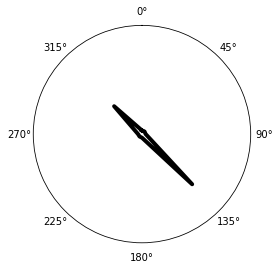

In [8]:
from utils.polarplot import *
from utils.polardata import *
from utils.data_wrappers import *
 
polardata = get_avg_normalized_response(
        boc=boc,
        session_id=exp_id,
        cell_specimen_id = cell_specimen_id,
        temporal_frequency=2.0)
theta, r = convert_polar_dict_to_arrays(polardata)
fig, axes = plt.subplots(nrows=1, ncols=1, subplot_kw=dict(polar=True))
polar_plot(axes, theta, r, color='black', linewidth=4)


# Polar plot for all cells in one experiment

Apply **filtering** for cells in this experiment

In [9]:
exps = boc.get_ophys_experiments(
    experiment_container_ids=[ec_id],
    stimuli=[stim_info.DRIFTING_GRATINGS])
exps = pd.DataFrame.from_dict(exps)
cells = boc.get_cell_specimens()
cells = pd.DataFrame.from_records(cells)

dg_response_filter = get_dg_response_filter_from_saskia()
in_category_cells = cells[cells.experiment_container_id == ec_id]
filtered_cells = get_filtered_cells(in_category_cells, dg_response_filter)
filtered_cells = filtered_cells[filtered_cells.dsi_dg > 0.5]
print ("In this experiment, we have", len(in_category_cells),
       "cells, but after filtering, we have", len(filtered_cells), "cells")


In this experiment, we have 243 cells, but after filtering, we have 37 cells


In [10]:
thetas = []
rs = []
cell_ids = []
for cell_specimen_id in filtered_cells.cell_specimen_id:
    one_cell_polar_data_dict = get_avg_normalized_response(
        boc=boc,
        session_id=exp_id,
        cell_specimen_id = cell_specimen_id,
        temporal_frequency=2.0)
    if one_cell_polar_data_dict is None:
        continue
    theta, r = convert_polar_dict_to_arrays(one_cell_polar_data_dict)
    thetas.append(theta)
    rs.append(r)
    cell_ids.append(cell_specimen_id)

/home/stephen/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/stephen/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/stephen/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/stephen/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/stephen/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use 

/home/stephen/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/stephen/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/stephen/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/stephen/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/stephen/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use 

/home/stephen/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/stephen/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/stephen/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/stephen/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/stephen/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use 

/home/stephen/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/stephen/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/stephen/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/stephen/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/stephen/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use 

/home/stephen/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/stephen/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/stephen/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/stephen/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/stephen/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use 

KeyboardInterrupt: 

In [ ]:
agg_theta, agg_r = get_avg_polar(thetas, rs)
# Or use get_median_polar

fig, axes = plt.subplots(nrows=1, ncols=1, subplot_kw=dict(polar=True))
polar_plot_population(ax=axes,
                      bold_theta = agg_theta,
                      bold_r = agg_r,
                      grey_thetas = thetas, 
                      grey_rs = rs)

Let's see each cell's polar plot

In [ ]:
for i in range(len(thetas)):
    cell_id = cell_ids[i]
    print ("cell id", cell_id)
    cell_df = filtered_cells[filtered_cells.cell_specimen_id == cell_id]
    print ("g_dsi_dg", cell_df.g_dsi_dg.values[0])
    print ("dsi_dg", cell_df.dsi_dg.values[0])
    print ("p_dg", cell_df.p_dg.values[0])
    print ("pref_dir_dg", cell_df.pref_dir_dg.values[0])
    fig, axes = plt.subplots(nrows=1, ncols=1, subplot_kw=dict(polar=True))
    polar_plot(axes, thetas[i], rs[i])
    plt.show()